## Anomaly Detection in ECG data

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import arff
import torch
from torch import nn
from sklearn.model_selection import train_test_split
from typing import List, Tuple
from torch.utils.data import Dataset

In [2]:
device = 'gpu' if torch.cuda.is_available() else 'cpu'
device

'gpu'

- training data

In [3]:
with open('ECG5000/ECG5000_TRAIN.arff', 'r') as f:
    arff_file = arff.loadarff(f)
    df_train = pd.DataFrame(arff_file[0])
    
df_train.head()

,att1,att2,att3,att4,att5,att6,att7,att8,att9,att10,...,att132,att133,att134,att135,att136,att137,att138,att139,att140,target
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,b'1'
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,b'1'
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,b'1'
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,b'1'
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,b'1'


In [4]:
print(df_train.shape)
print(df_train.describe())

(500, 141)
             att1        att2        att3        att4        att5        att6  \
count  500.000000  500.000000  500.000000  500.000000  500.000000  500.000000   
mean    -0.159100   -1.551951   -2.442733   -3.098292   -3.177269   -2.899259   
std      1.140292    1.416321    1.400143    1.325583    1.128045    0.904602   
min     -3.694197   -5.117621   -5.110389   -5.060774   -5.375715   -5.056184   
25%     -0.928707   -2.644930   -3.617218   -4.251520   -4.022823   -3.537361   
50%     -0.216883   -1.539340   -2.513000   -3.309532   -3.541513   -3.008340   
75%      0.582008   -0.595632   -1.448769   -2.199136   -2.546305   -2.432860   
max      4.058127    2.087844    1.592974    1.423006    1.014557    0.610640   

             att7        att8        att9       att10  ...      att131  \
count  500.000000  500.000000  500.000000  500.000000  ...  500.000000   
mean    -2.286133   -1.800159   -1.429717   -0.948419  ...    0.146861   
std      0.697134    0.575725    0.58

- test data

In [5]:
with open('ECG5000/ECG5000_TEST.arff', 'r') as f:
    arff_file = arff.loadarff(f)
    df_test = pd.DataFrame(arff_file[0])
    
print(df_test.head())
print(df_test.shape)

       att1      att2      att3      att4      att5      att6      att7  \
0  3.690844  0.711414 -2.114091 -4.141007 -4.574472 -3.431909 -1.950791   
1 -1.348132 -3.996038 -4.226750 -4.251187 -3.477953 -2.228422 -1.808488   
2  1.024295 -0.590314 -1.916949 -2.806989 -3.527905 -3.638675 -2.779767   
3  0.545657 -1.014383 -2.316698 -3.634040 -4.196857 -3.758093 -3.194444   
4  0.661133 -1.552471 -3.124641 -4.313351 -4.017042 -3.005993 -1.832411   

       att8      att9     att10  ...    att132    att133    att134    att135  \
0 -1.107067 -0.632322  0.334577  ...  0.022847  0.188937  0.480932  0.629250   
1 -1.534242 -0.779861 -0.397999  ...  1.570938  1.591394  1.549193  1.193077   
2 -2.019031 -1.980754 -1.440680  ...  0.443502  0.827582  1.237007  1.235121   
3 -2.221764 -1.588554 -1.202146  ...  0.777530  1.119240  0.902984  0.554098   
4 -1.503886 -1.071705 -0.521316  ...  1.280823  1.494315  1.618764  1.447449   

     att136    att137    att138    att139    att140  target  
0  0.5

- combine train and test data (unsupervised learning) 

In [6]:
data = pd.concat([df_train, df_test], axis=0)
print(data.shape)

(5000, 141)


### Autoencoder training on normal (N) data

In [28]:
CLASS_NORMAL = b'1'

class_names = ['Normal', 'R on T', 'PVC', 'SP', 'UB']

print(data['target'].unique())

[b'1' b'2' b'3' b'4' b'5']


- data preprocessing

In [8]:
data['target'].value_counts()

target
b'1'    2919
b'2'    1767
b'4'     194
b'3'      96
b'5'      24
Name: count, dtype: int64

In [9]:
# shuffle
data = data.sample(frac=1).reset_index(drop=True)

In [10]:
def plot_time_series_class(data, class_name, ax, n_steps=10):
    '''
    plots a time series along with a shaded area representing the standard deviation.

    Parameters:
    - data (array-like): Time series data (e.g., list, NumPy array, or DataFrame).
    - class_name (str): Name of the class/series, used as the plot title.
    - ax (matplotlib.axes.Axes): The axis object on which the plot will be drawn.
    - n_steps (int, optional): Rolling window size for calculating the mean and standard deviation. Default is 10.

    Plot:
    - Solid line: Rolling mean of the time series.
    - Shaded area: Standard deviation interval (mean ± 2 * standard deviation). 
    '''
    time_series_df = pd.DataFrame(data)
    
    path = time_series_df.rolling(n_steps, min_periods=1).mean()
    path_deviation = 2 * time_series_df.rolling(n_steps, min_periods=1).std()
    
    path = path.iloc[:, 0]
    path_deviation = path_deviation.iloc[:, 0]
    
    under_line = (path - path_deviation).values
    over_line = (path + path_deviation).values
    
    ax.plot(path, linewidth=2, label=class_name)
    ax.fill_between(
        path_deviation.index,
        under_line,
        over_line,
        alpha=0.125,
        color='blue'  
    )
    ax.set_title(class_name)
    ax.legend()

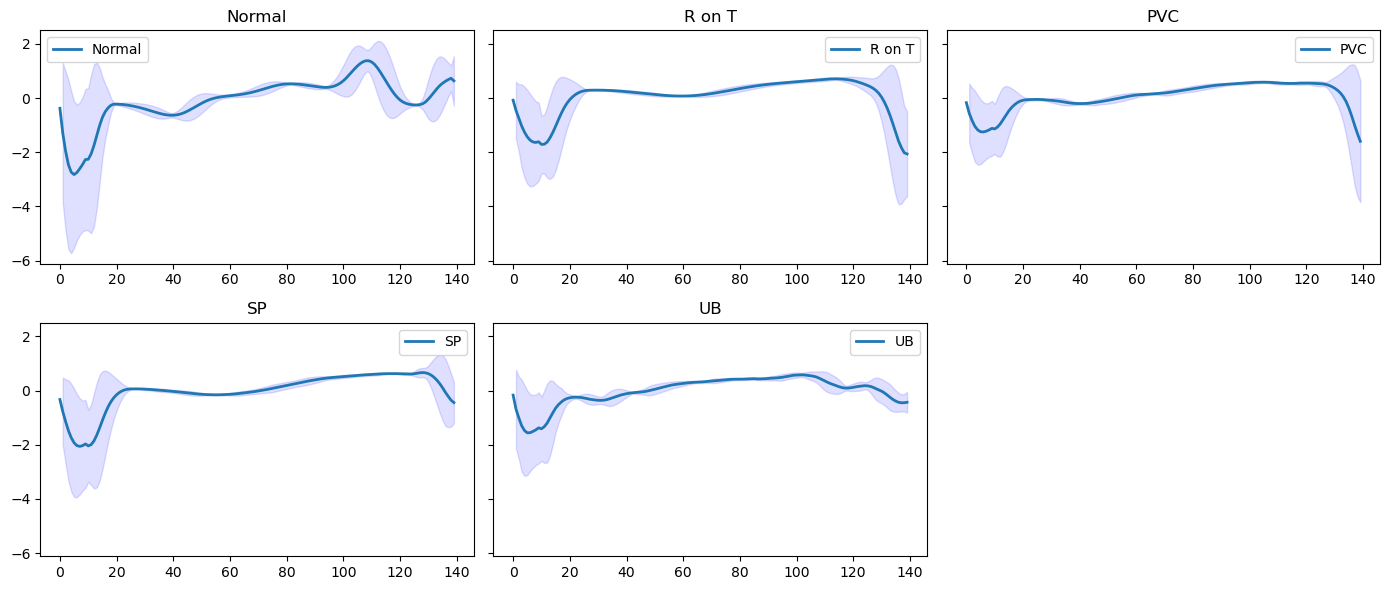

In [11]:
classes = data['target'].unique()

fig, axs = plt.subplots(
    nrows=len(classes) // 3 + 1,
    ncols=3,
    sharey=True,
    figsize=(14, 6)
)

for i, cls in enumerate(classes):
    ax = axs.flat[i]
    
    temp_data = data[data['target'] == cls].drop(labels='target', axis=1).mean(axis=0).to_numpy()
    
    plot_time_series_class(temp_data, class_names[i], ax)

fig.delaxes(axs.flat[-1])

fig.tight_layout()
plt.show()

- datasets:

In [48]:
class TimeSeriesDataset(Dataset):

    def __init__(self, sequences: List[np.ndarray]):
        """
        :param sequences: list of sequences (np.ndarray)
        """
        self.sequences = [torch.tensor(seq, dtype=torch.float32).unsqueeze(1) for seq in sequences]
        self.seq_len = len(self.sequences[0])
        self.n_features = self.sequences[0].shape[1]

    def __len__(self) -> int:
        return len(self.sequences)

    def __getitem__(self, idx: int) -> torch.Tensor:
        return self.sequences[idx]

    def get_len(self) -> int:
        return self.seq_len
    

def split_data(data: pd.DataFrame, target_column: str, normal_class: str, test_size: float = 0.2, val_size: float = 0.5, random_state: int = 42) \
               -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    Splits normal data into train, val, test and anomalies.
    """
    normal_data = data[data[target_column] == normal_class].drop(columns=[target_column])
    anomalies_data = data[data[target_column] != normal_class].drop(columns=[target_column])

    train_data, test_data = train_test_split(normal_data, test_size=test_size, random_state=random_state)
    val_data, test_data = train_test_split(test_data, test_size=val_size, random_state=random_state)

    return train_data, val_data, test_data, anomalies_data


def create_datasets(train_data: pd.DataFrame, val_data: pd.DataFrame, test_data: pd.DataFrame, anomalies_data: pd.DataFrame) \
                    -> Tuple[TimeSeriesDataset, TimeSeriesDataset, TimeSeriesDataset, TimeSeriesDataset]:
    """Creates datasets from splitted ddata.
    """
    train_dataset = TimeSeriesDataset(train_data.to_numpy())
    val_dataset = TimeSeriesDataset(val_data.to_numpy())
    test_normal_dataset = TimeSeriesDataset(test_data.to_numpy())
    test_anomaly_dataset = TimeSeriesDataset(anomalies_data.to_numpy())

    return train_dataset, val_dataset, test_normal_dataset, test_anomaly_dataset

In [49]:
# DATA SPLITS
train_data, val_data, test_data, anomalies_data = split_data(data, target_column='target', normal_class=CLASS_NORMAL)

# DATASETS
train_dataset, val_dataset, test_normal_dataset, test_anomaly_dataset = create_datasets(train_data, val_data, test_data, anomalies_data)

 # DATASET STATS
print(f"Train dataset: {len(train_dataset)} sequences, seq_len={train_dataset.get_len()}")
print(f"Validation dataset: {len(val_dataset)} sequences, seq_len={val_dataset.get_len()}")
print(f"Test normal dataset: {len(test_normal_dataset)} sequences, seq_len={test_normal_dataset.get_len()}")
print(f"Test anomaly dataset: {len(test_anomaly_dataset)} sequences, seq_len={test_anomaly_dataset.get_len()}")

Train dataset: 2335 sequences, seq_len=140
Validation dataset: 292 sequences, seq_len=140
Test normal dataset: 292 sequences, seq_len=140
Test anomaly dataset: 2081 sequences, seq_len=140
